In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re  # for re.split

import torch

In [2]:
with open('moby_dick_10_chapters.txt','r') as f:
    moby = f.read()

# Split into words by blanks and newlines
moby = re.split('[ \n]', moby)
# Remove punctuation and space from left and right of each word.
# Convert all characters to lower case
moby = [word.strip(',. ;:?!+"\'').lower() for word in moby]
# Remove emtpy string 
moby = [word for word in moby if word != '' and word != ' ']
print(f'Text has {len(moby)} words.')
      
vocab = list(set(moby))
vocab_size = len(vocab)

print(f'Vocabulary has {vocab_size} words.')

Text has 19588 words.
Vocabulary has 4410 words.


In [3]:
# make tri-grams
trigrams = [(moby[i], moby[i+1], moby[i+2]) for i in range(len(moby) - 2)]

# Convert words into vocab indices
trigrams_indices = [(vocab.index(w0), vocab.index(w1), vocab.index(w2))
                    for (w0, w1, w2) in trigrams]
len(trigrams_indices)

19586

In [4]:
# Convert indices into one_hot indicator variables
def make_one_hot(index):
    one_hot = np.zeros(len(vocab))
    one_hot[index] = 1
    return one_hot

X = [(make_one_hot(i0), make_one_hot(i1))
     for (i0, i1, _) in trigrams_indices]
T = [i2 for (_, _, i2) in trigrams_indices]

X = np.array(X)  # (N, 2, 97)
X = X.reshape(-1, 2 * len(vocab))

T = np.array(T)  # .reshape(-1, 1)
X.shape, T.shape

((19586, 8820), (19586,))

In [5]:
X = torch.tensor(X.astype(np.float32)).reshape((-1, 1, X.shape[1]))
T = torch.tensor(T)
X.shape, T.shape

(torch.Size([19586, 1, 8820]), torch.Size([19586]))

In [6]:
ntrain = int(X.shape[0] * 0.8)
Xtrain = X[:ntrain, :]
Ttrain = T[:ntrain]
Xtest = X[ntrain:, :]
Ttest = T[ntrain:]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

(torch.Size([15668, 1, 8820]),
 torch.Size([15668]),
 torch.Size([3918, 1, 8820]),
 torch.Size([3918]))

We can use a layer of convolutional units to learn the embeddings.  The pair of words will be presented as a vector of length $2$ $\times $`vocab_size` of mostly zeros, but with two ones to indicate the position in the vocabulary of each of the two words.

The convolutional units will have kernel size of `vocab_size` and will be shifted with a stride of `vocab_size`. Thus, each unit will calculate two dot products of its weights and the input, once for the first word and once for the second word.

Epoch 20 error 6.50500
Epoch 40 error 5.86814
Epoch 60 error 5.15277
Epoch 80 error 4.41863
Epoch 100 error 3.67238
Epoch 120 error 3.05065
Epoch 140 error 2.61243
Epoch 160 error 2.32269
Epoch 180 error 2.12235
Epoch 200 error 1.97902
Got 56.2 of training samples correct
Got 4.0 of training samples correct


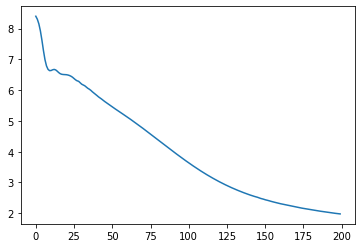

In [7]:
ndim_embedding = 8
learning_rate = 0.01
n_epochs = 200

nnet = torch.nn.Sequential(
    torch.nn.Conv1d(1, ndim_embedding, vocab_size, stride=vocab_size),
    torch.nn.Tanh(),
    torch.nn.Flatten(),
    torch.nn.Linear(ndim_embedding * 2, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 50),
    torch.nn.Tanh(),
    # torch.nn.Linear(50, 3),
    # torch.nn.Tanh(),
    # torch.nn.Linear(3, 50),
    # torch.nn.Tanh(),
    # torch.nn.Linear(50, 100),
    # torch.nn.Tanh(),
    torch.nn.Linear(50, vocab_size))

error_trace = []
loss_F = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)

nnet.train()

for epoch in range(n_epochs):
    
    optimizer.zero_grad()
    Y = nnet(Xtrain)
    error = loss_F(Y, Ttrain)
    error_trace.append(error)
    error.backward()
    optimizer.step()
    
    if (epoch + 1) % (max(1, n_epochs // 10)) == 0 or epoch == n_epochs-1:
        print(f'Epoch {epoch+1} error {error:.5f}')

nnet.eval()

plt.figure(1)
plt.clf()
plt.plot(error_trace)

Ytrain = nnet(Xtrain)
Ytrain_classes = torch.argmax(Ytrain, axis=1)
percent_correct = float((Ytrain_classes == Ttrain).sum()) / len(Ttrain) * 100
print(f'Got {percent_correct:.1f} of training samples correct')

Ytest = nnet(Xtest)
Ytest_classes = torch.argmax(Ytest, axis=1)
percent_correct = float((Ytest_classes == Ttest).sum()) / len(Ttest) * 100
print(f'Got {percent_correct:.1f} of training samples correct')

In [8]:
import pandas

for_dataframe = []
for i in range(0, 10 * 50, 9):
    for_dataframe.append([trigrams[i], vocab[Ttrain[i]], vocab[Ytrain_classes[i]]])
print('Train Data')
pandas.DataFrame(for_dataframe, columns=('the trigram', 'third word', 'predicted third word'))

Train Data


,the trigram,third word,predicted third word
0,"(chapter, 1, loomings)",loomings,loomings
1,"(mind, how, long)",long,landlord
2,"(my, purse, and)",and,and
3,"(shore, i, thought)",thought,thought
4,"(and, see, the)",the,a
5,"(is, a, way)",way,mighty
6,"(spleen, and, regulating)",regulating,regulating
7,"(growing, grim, about)",about,about
8,"(damp, drizzly, november)",november,november
9,"(myself, involuntarily, pausing)",pausing,pausing


In [9]:
for_dataframe = []
for i in range(0, 10 * 50, 9):
    for_dataframe.append([trigrams[ntrain + i], vocab[Ttest[i]], vocab[Ytest_classes[i]]])
print('Test Data')
pandas.DataFrame(for_dataframe, columns=('the trigram', 'third word', 'predicted third word'))

Test Data


,the trigram,third word,predicted third word
0,"(we, sail, with)",with,for
1,"(he, slowly, answered)",answered,he
2,"(sir?'—'soon, enough, for)",for,he
3,"(passenger, ha, jonah)",jonah,and
4,"(calls, away, the)",the,he
5,"(with, ye,'—he, says,—'the)","says,—'the",what
6,"(pay, now, for)",for,and
7,"(if, it, were)",were,was
8,"(in, this, history)",history,bed
9,"(ere, the, craft)",craft,only


[ 145  493 1218 3544 2883 4359    3 2012 2362 1354]
[1814 4343 3243 1405 1823 3440 1454 2362 3643 1961]
[3655  241 2284 3929 1092 3563 2454 2568 3897 1186]
[3954 3742 3491  458 4306  759  862  547 4304 1257]
[4099 2329 1568 3944 1411  340 3277 2851 2930 2229]
[ 797 4057 2671 1814 4256 2568 3944  486  434 2166]
[ 103 3076 3580 3721  870 1734 2207  114 3120 1733]
[ 331 4141 2612 1669  557 3157  848 4187   12 4208]


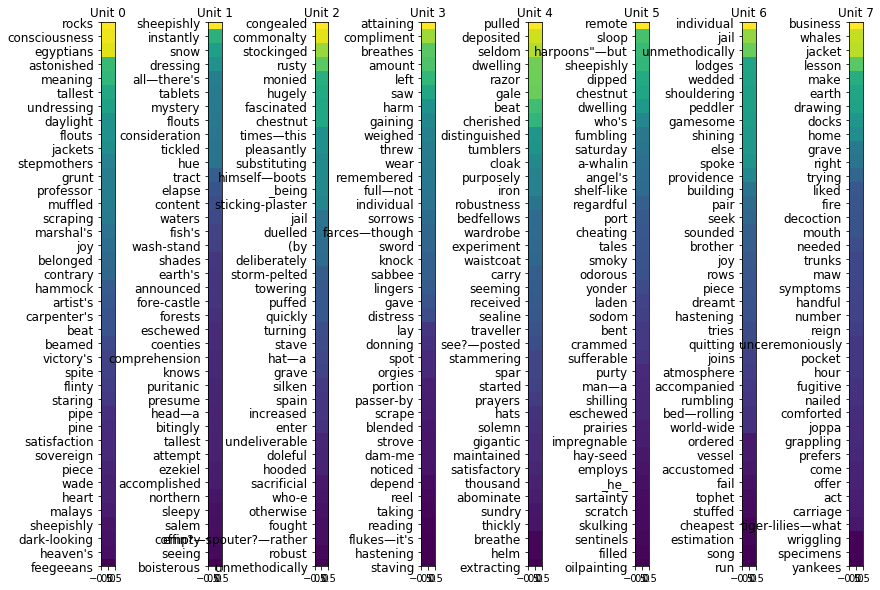

In [10]:
weights = nnet[0].weight.detach().numpy().squeeze()

plt.figure(figsize=(15, 10))
show_n = 40

ploti = 0
for i in range(ndim_embedding):
    ploti += 1
    plt.subplot(1, ndim_embedding, ploti)
    unitw = weights[i, :]
    order = np.argsort(-unitw)
    print(order[:10])
    plt.imshow(unitw[order][:show_n].reshape(-1, 1), interpolation='nearest')
    plt.yticks(range(show_n), np.array(vocab)[order[:show_n]], fontsize=12)
    plt.title(f'Unit {i}')

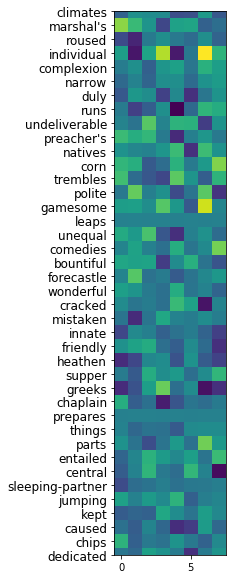

In [11]:
n0, n1 = (100, 140)
plt.figure(figsize=(15, 10))
plt.imshow(weights.T[n0:n1], interpolation='nearest')
plt.yticks(range(n1 - n0), vocab[n0:n1], fontsize=12);

In [12]:
def get_layer_output(nnet, X_sample, layer):
    nnet.eval()
    outputs = []
    reg = nnet[layer * 2].register_forward_hook(
        lambda self, i, o: outputs.append(o))
    # nnet.use(X_sample)
    nnet(X_sample)
    reg.remove()
    output = outputs[0].detach().numpy()
    return output

embedding = get_layer_output(nnet, X, 1)
check_n_words = 20
for i in range(check_n_words):
    print(trigrams[i][:2])
    print(embedding[i].reshape((-1, 2)).T)


('chapter', '1')
[[ 0.77440035 -0.1963626  -0.15330842 -0.21133101 -0.1448606  -0.03358192
  -0.66067845  0.5667293 ]
 [-0.09482644  0.64078546  0.32898247 -0.10541049  0.09827431  0.6467912
  -0.22349101 -0.5839234 ]]
('1', 'loomings')
[[-0.09482644  0.64078546  0.32898247 -0.10541049  0.09827431  0.6467912
  -0.22349101 -0.5839234 ]
 [-0.6340507  -0.02137255 -0.7156365  -0.1912915  -0.83041626  0.00619935
  -0.3822365  -0.529863  ]]
('loomings', 'call')
[[-6.3405073e-01 -2.1372553e-02 -7.1563649e-01 -1.9129150e-01
  -8.3041626e-01  6.1993510e-03 -3.8223651e-01 -5.2986300e-01]
 [-1.9958627e-01 -7.5919425e-01  2.8821075e-01  6.0890973e-01
   1.5709549e-05 -2.4942927e-01  2.0973022e-01 -1.0369455e-01]]
('call', 'me')
[[-1.9958627e-01 -7.5919425e-01  2.8821075e-01  6.0890973e-01
   1.5709549e-05 -2.4942927e-01  2.0973022e-01 -1.0369455e-01]
 [-1.8268189e-01 -6.6945396e-02 -1.8982984e-01 -1.2927510e-01
  -8.4530890e-02 -1.6906075e-01  3.2689053e-01  2.0846310e-01]]
('me', 'ishmael')
[[-0.

In [13]:
first_words = np.array([tg[0] for tg in trigrams])
first_embeddings = embedding[:, :ndim_embedding]
order = np.lexsort(([first_embeddings[:, i] for i in range(first_embeddings.shape[1]-1, -1, -1)]))

In [14]:
first_embeddings[order[:5], :]

array([[-0.9486038 , -0.40697676,  0.42167354, -0.14107949,  0.20563929,
        -0.01261118,  0.22833376, -0.05719731],
       [-0.9336974 , -0.6969555 ,  0.25368333,  0.05546357,  0.09680267,
        -0.5192709 , -0.87184113,  0.69183135],
       [-0.9336974 ,  0.05093087,  0.25368333,  0.34161663,  0.09680267,
         0.34228122, -0.87184113,  0.16800879],
       [-0.9336974 ,  0.12997714,  0.25368333,  0.4559192 ,  0.09680267,
         0.09722175, -0.87184113, -0.39110345],
       [-0.932895  , -0.5569554 , -0.03569118, -0.4421954 ,  0.3946311 ,
        -0.24733256, -0.17631657,  0.41581002]], dtype=float32)

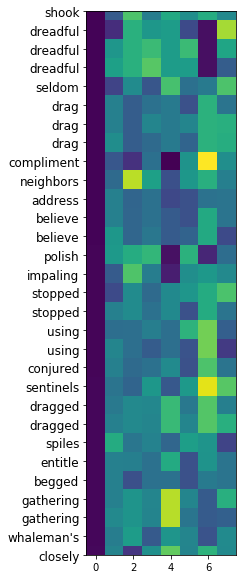

In [21]:
plt.figure(figsize=(15, 10))
plt.imshow(first_embeddings[order[:30], :])
plt.yticks(range(30), first_words[order[:30]], fontsize=12);